In [39]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
from numpy import ndarray
from scipy.optimize import minimize
from scipy.special import inv_boxcox
from scipy.stats import boxcox
from sklearn import metrics
import pandas as pd
import yfinance as yf
from sklearn.model_selection import train_test_split

[*********************100%***********************]  1 of 1 completed


<AxesSubplot: xlabel='Date'>

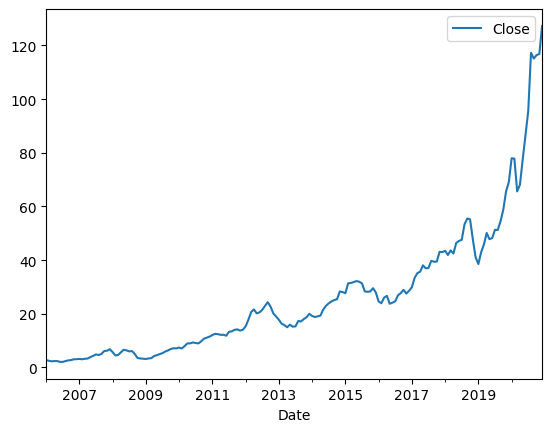

In [40]:
df = pd.DataFrame(yf.download('AAPL', '2006-01-01', '2021-01-01').resample("M").mean().Close)
df.plot()

## Triple exponential smoothing (aka HoltWinters (multiplicative))
Sources:
* [Exponential smoothing (Wikipedia)](https://en.wikipedia.org/wiki/Exponential_smoothing#Triple_exponential_smoothing_(Holt_Winters))
* [Triple Exponential Smoothing (National Institute of Standards and Technology)](https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc435.htm)
* [Time Series From Scratch — Exponential Smoothing Theory and Implementation](https://towardsdatascience.com/time-series-from-scratch-exponential-smoothing-theory-and-implementation-6683eb271bad)

In [41]:
class HoltWinters:
    def __init__(self, y: ndarray, l: int, alpha: float, beta: float, gamma: float):
        self._y = y
        self.l = l

        # Initial value for smoothed level
        s = np.empty(y.size)
        s[0] = y[0]

        # Initial value for trend
        b = np.empty(y.size)
        b[0] = np.sum(y[l:l + l] - y[:l]) / (l * l)

        # Mean value in each season
        a = np.mean(np.array_split(y, y.size / l), axis=1)

        # Initial values for seasonality
        c = np.empty(y.size)
        for i in range(l):
            assert y[i::l].size == a.size
            c[i] = np.sum(y[i::l] / a) / (y.size / l)

        for t in range(1, y.size):
            s[t] = alpha * y[t] / (c[t - l] if t >= l else 1) + (1 - alpha) * (s[t - 1] + b[t - 1])
            b[t] = beta * (s[t] - s[t - 1]) + (1 - beta) * b[t - 1]
            if t >= l:
                c[t] = gamma * y[t] / s[t] + (1 - gamma) * c[t - l]
        self.s, self.b, self.c = s, b, c

    def model(self):
        return (self.s + self.b) * self.c

    def forecast(self, m: int, t: int = None):
        if t is None:
            t = self.s.size - 1
        f = np.empty(m)
        for i in range(1, m + 1):
            f[i - 1] = (self.s[t] + i * self.b[t]) * self.c[t - self.l + 1 + (i - 1) % self.l]
        return f

    def score(self, y_test: ndarray):
        return metrics.mean_absolute_percentage_error(y_test, self.forecast(y_test.size))

MAPE: 0.16326200534055887


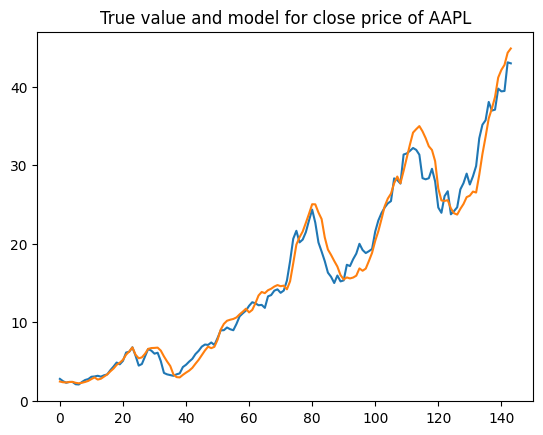

In [42]:
x_train, x_test = train_test_split(df, test_size=0.2, shuffle=False)

model = HoltWinters(df[:144].Close, l=12, alpha=0.2, beta=0.2, gamma=0.2)
print("MAPE:", model.score(df[144:]))
plt.plot(np.array(df[:144].Close))
plt.plot(model.model())
plt.title('True value and model for close price of AAPL')
plt.show()

In [43]:
def minimizer(x: ndarray):
    return HoltWinters(df[:144].Close, l=12, alpha=x[0], beta=x[1], gamma=x[2]).score(x_test)

r = minimize(minimizer, np.array([0.5, 0.5, 0.5]), method='nelder-mead')

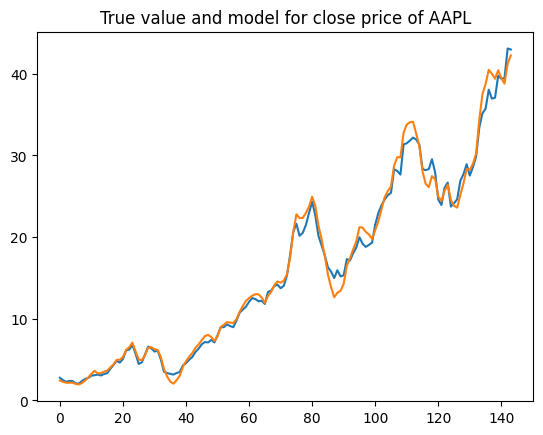

In [44]:
alpha, beta, gamma = r.x
model = HoltWinters(df[:144].Close, l=12, alpha=alpha, beta=beta, gamma=gamma)
plt.plot(np.array(df[:144].Close))
plt.plot(model.model())
plt.title('True value and model for close price of AAPL')
plt.show()

MAPE: 0.15229303274107842


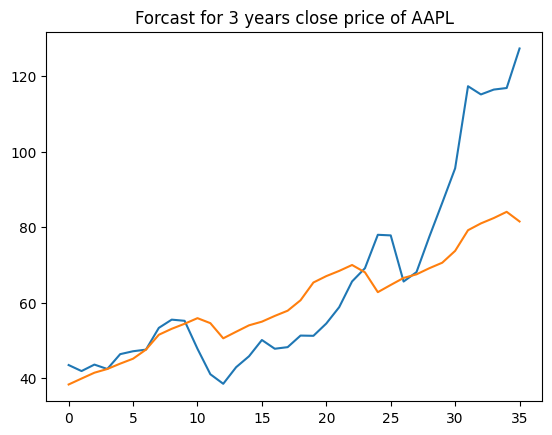

In [45]:
print("MAPE:", model.score(x_test))
plt.plot(np.array(x_test.Close))
plt.plot(model.forecast(36))
plt.title('Forcast for 3 years close price of AAPL')
plt.show()

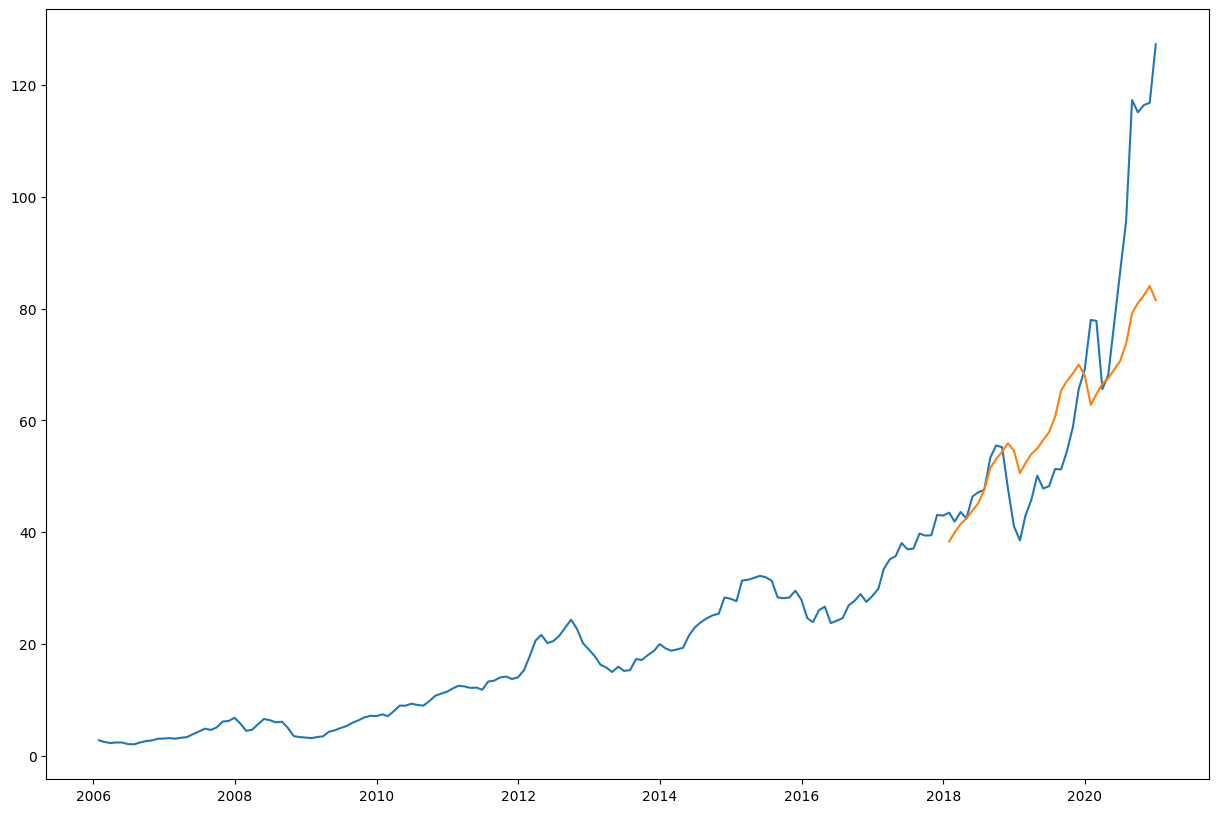

In [46]:
plt.figure(figsize=(15, 10))
plt.plot(df)
idx = pd.date_range(df.index[144], periods=x_test.size, freq='M')
plt.plot(pd.Series(model.forecast(36), index=idx))